In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import torch
import torch.utils.data
import random
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision.utils import save_image
import math
import torch.nn as nn
from torch.nn import init
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset
import matplotlib.pyplot as plt
from torch.distributions import OneHotCategorical

In [2]:
class Encoder(nn.Module):
    def __init__(self, H, K):
        super().__init__()
        self.fc1 = nn.Linear(784, 400)
        self.fc2 = nn.Linear(400, H * K)
        self.H = H
        self.K = K

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = x.view(x.size(0), self.H, self.K)
        x = F.softmax(x, dim = -1)
        return x

class Decoder(nn.Module):
    def __init__(self, H, K):
        super().__init__()
        self.fc1 = nn.Linear(H * K, 400)
        self.fc2 = nn.Linear(400, 784)

    def forward(self, z):
        z = z.view(z.size(0), -1)
        z = self.fc1(z)
        z = F.relu(z)
        z = self.fc2(z)
        z = torch.sigmoid(z)
        z = z.view(z.size(0), 1, 28, 28)
        return z

In [3]:
class VAE(nn.Module):
    def __init__(self, input_size, latent_size=20, latent_categories=256):
        super(VAE, self).__init__()
        self.input_size = input_size # img_H * img_W
        self.num_latent_vars = latent_size # H, number of latent categorical variables
        self.card_latent_vars = latent_categories # K, the number of categories for each latent variable  
        self.encoder = Encoder(latent_size, latent_categories)
        self.decoder = Decoder(latent_size, latent_categories)

    def forward(self, x):
        """
        Performs forward pass through VAE model by passing image through 
        encoder, reparametrize trick, and decoder models
    
        Inputs:
        - x: Batch of input images of shape (N, 1, H, W)
        
        Returns:
        - x_hat: Reconstructed input data of shape (N,1,H,W)
        - p: A tensor of shape (N, H, K) representing N estimated latent posterior distributions, each being H categorical variables with K categories. 
        """
        p = self.encoder(x)
        z = self.reparametrize(p)
        x_hat = self.decoder(z)

        return x_hat, p

    def reparametrize(self, p):
        """
        Differentiably sample categorical random variables with specified category probabilities using the
        reparameterization trick. For a reference, see the notes referred to in the latex file.

        Implement the Gumbel-Softmax trick manually.                                       
        1. Sample u from a uniform distribution U(0, 1) with the same shape as p.                
        2. Use inversion sampling to compute g from u to get Gumbel sample.                       
        3. Compute y = (log(p) + g) to get the logits.      
        4. Apply softmax to y with temperature 1 to get the final sample.                                     

        Inputs:
        - p: A tensor of shape (N, H, K) giving the parameters of categorical variable.

        Returns: 
        - z: Differetialbly sampled latent vectors
        """
        if self.training:
            u = torch.rand_like(p)
            g = -torch.log(-torch.log(u))
            y = torch.log(p + 1e-20) + g
            z = F.softmax(y, dim = -1)
        else:
            z = OneHotCategorical(p).sample()
        return z

In [4]:
def loss_function(x_hat, x, p):
    """
    Computes the negative variational lower bound loss term of the discrete VAE (refer to formulation in the notes referred to in the latex).

    Inputs:
    - x_hat: Reconstruced input data of shape (N, 1, H, W)
    - x: Input data for this timestep of shape (N, 1, H, W)
    - p: A tensor of shape (N, H, K) giving the parameters of categorical variable.

    
    Returns:
    - loss: Tensor containing the scalar loss for the negative variational lowerbound
    """
    recon_loss = F.binary_cross_entropy(x_hat.view(-1, 784), x.view(-1, 784), reduction='sum')
    h = -torch.sum(p * torch.log(p + 1e-20), dim = -1)
    K = p.size(-1)
    kl_div = torch.sum((torch.log(torch.tensor(K, dtype=p.dtype)) - h), dim = -1)
    total_loss = recon_loss - torch.sum(kl_div)
    loss = total_loss / x.size(0)
    
    return loss

In [5]:
def train_vae(epoch, model, train_loader):
    """
    Train a VAE

    Inputs:
    - epoch: Current epoch number 
    - model: VAE model object
    - train_loader: PyTorch Dataloader object that contains our training data
    """
    model.train()
    train_loss = 0
    num_classes = 10
    loss = None
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    for batch_idx, (data, labels) in enumerate(train_loader):
        recon_batch, p = model(data)
        optimizer.zero_grad()
        loss = loss_function(recon_batch, data, p)
        loss.backward()
        train_loss += loss.data
        optimizer.step()
    print('Train Epoch: {} \tLoss: {:.6f}'.format(
        epoch, loss.data))

In [7]:
random.seed(0)
torch.manual_seed(0)
batch_size = 128
mnist_train = dset.MNIST('./data', train=True, download=True,
                           transform=T.ToTensor())
loader_train = DataLoader(mnist_train, batch_size=batch_size,
                          shuffle=True, drop_last=True, num_workers=2)

num_epochs = 10
latent_size = 20
latent_categories = 256
input_size = 28*28
vae_model = VAE(input_size, latent_size=latent_size, latent_categories=latent_categories)
for epoch in range(0, num_epochs):
    train_vae(epoch, vae_model, loader_train)

Train Epoch: 0 	Loss: 93.967026
Train Epoch: 1 	Loss: 103.982994
Train Epoch: 2 	Loss: 86.043457
Train Epoch: 3 	Loss: 64.284241
Train Epoch: 4 	Loss: 50.367439
Train Epoch: 5 	Loss: 27.180687
Train Epoch: 6 	Loss: 22.841949
Train Epoch: 7 	Loss: 17.578835
Train Epoch: 8 	Loss: 22.657249
Train Epoch: 9 	Loss: 9.390656


In [8]:
# Part d
def reconstruction(model, loader_test, num_samples = 10):
    model.eval()
    images, _ = next(iter(loader_test))
    
    with torch.no_grad():
        recons_images, _ = model(images)
        recons_images = recons_images.clamp(0, 1)

    fig, ax = plt.subplots(ncols=10, figsize=(30, 5))
    for i in range(num_samples):
        ax[i].imshow(images[i].numpy().reshape(28, 28), cmap='gray')
        ax[i].axis('off')
        ax[i].set_title(f'original image {i}')
    plt.show()

    fig, ax = plt.subplots(ncols=10, figsize=(30, 5))
    for i in range(num_samples):
        ax[i].imshow(recons_images[i].numpy().reshape(28, 28), cmap='gray')
        ax[i].axis('off')
        ax[i].set_title(f'reconstructed image {i}')
    plt.show()
        

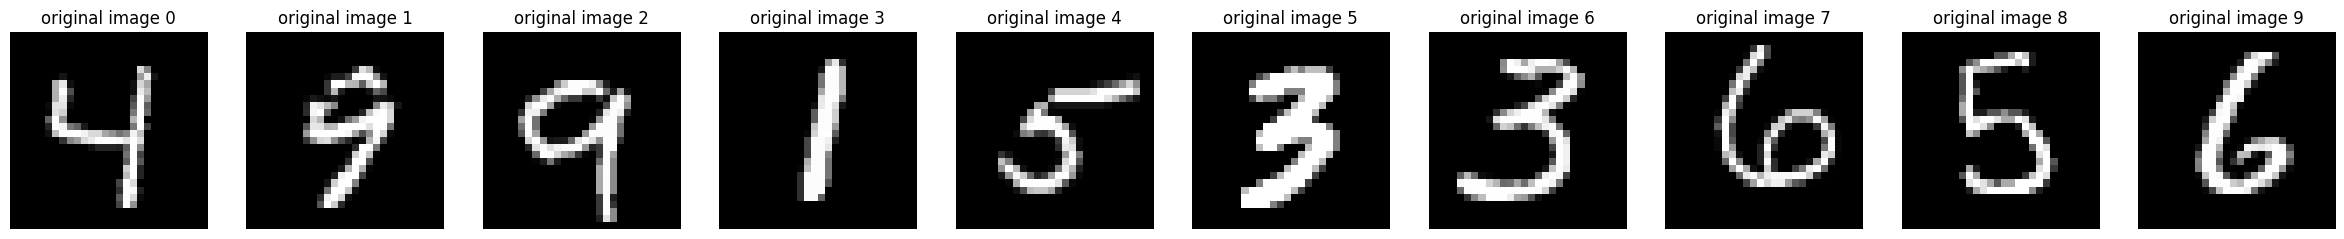

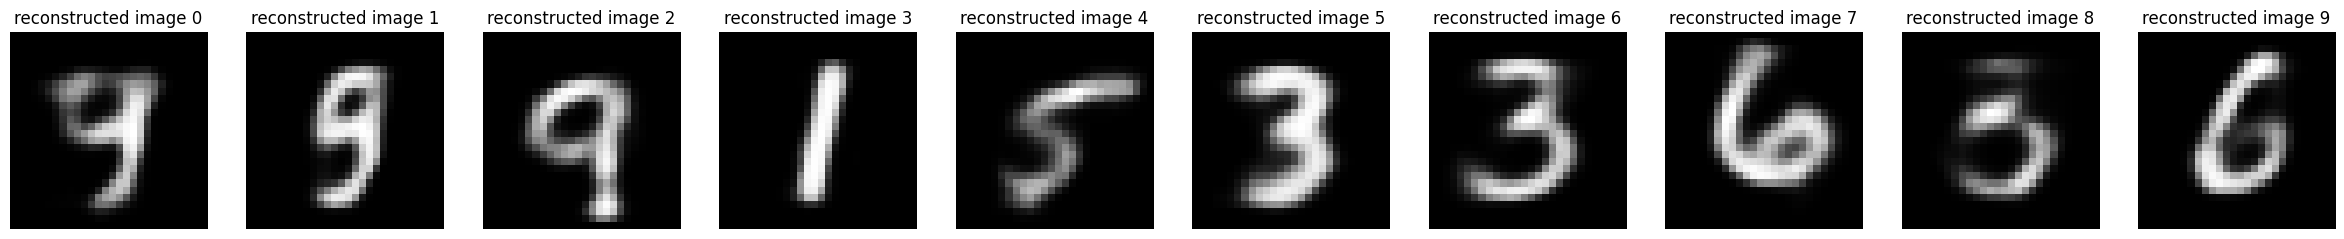

In [9]:
mnist_test = dset.MNIST('./data', train = False, download = True, transform = T.ToTensor())
loader_test = DataLoader(mnist_test, batch_size = batch_size, shuffle=True, drop_last = True, num_workers = 2)
reconstruction(vae_model, loader_test)

In [10]:
def novel_generation(model, H, K, num_samples = 10):
    model.eval()
    p_uniform = torch.rand(num_samples, H, K)
    with torch.no_grad():
        z_uniform = model.reparametrize(p_uniform)
        recons_images = model.decoder(z_uniform)

    fig, ax = plt.subplots(ncols=10, figsize=(30, 5))
    for i in range(num_samples):
        ax[i].imshow(recons_images[i].numpy().reshape(28, 28), cmap='gray')
        ax[i].axis('off')
        ax[i].set_title(f'novel recons image {i}')
    plt.show()

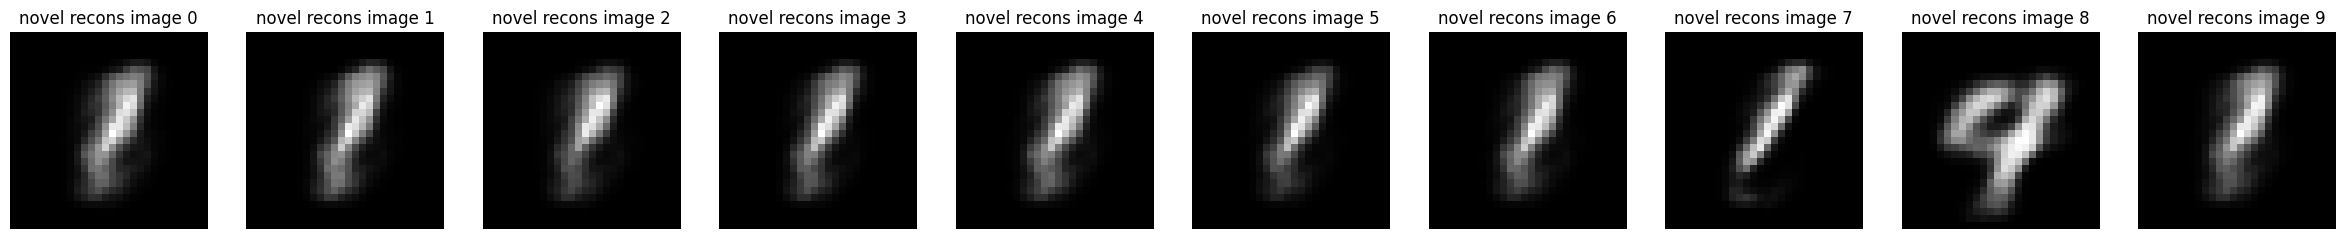

In [11]:
novel_generation(vae_model, latent_size, latent_categories)

Part F

In terms of reconstruction and novel sample generation, continuous VAE can perform better because the gaussian distribution can capture more smooth variations whereas categorical distribution is more rigid. In terms of trainning efficiency, discreate VAE can be trained faster since the loss function is easier to compute, but the loss is a bit higher compared to continuous case.